# Mapping Layer MNIST Example

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0,'../DEC-keras')
from DEC import DEC, cluster_acc

from sklearn.decomposition import PCA

from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.initializers import Initializer
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.engine.topology import Layer
from keras import backend as K

Using TensorFlow backend.
/Users/dwright/anaconda2/envs/aind/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Define some helpful methods

In [2]:
def load_dec(x, ae_weights, dec_weights, n_clusters, batch_size, lr, momentum):
  dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, batch_size=batch_size)
  ae_weights = ae_weights
  dec.initialize_model(optimizer=SGD(lr=lr, momentum=momentum),
                       ae_weights=ae_weights,
                       x=x, loss='kld')
  dec.load_weights(dec_weights)
  dec.model.summary()
  return dec

In [3]:
def get_cluster_to_label_mapping(y, y_pred, n_classes, n_clusters):

  one_hot_encoded = np_utils.to_categorical(y, n_classes)

  cluster_to_label_mapping = []
  n_assigned_list = []
  majority_class_fractions = []
  majority_class_pred = np.zeros(y.shape)
  for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    n_assigned_examples = cluster_indices.shape[0]
    n_assigned_list.append(n_assigned_examples)
    cluster_labels = one_hot_encoded[cluster_indices]
    cluster_label_fractions = np.mean(cluster_labels, axis=0)
    majority_cluster_class = np.argmax(cluster_label_fractions)
    cluster_to_label_mapping.append(majority_cluster_class)
    majority_class_pred[cluster_indices] += majority_cluster_class
    majority_class_fractions.append(cluster_label_fractions[majority_cluster_class])
    print(cluster, n_assigned_examples, majority_cluster_class, cluster_label_fractions[majority_cluster_class])
  print(cluster_to_label_mapping)
  return cluster_to_label_mapping, n_assigned_list, majority_class_fractions

In [4]:
def get_cluster_centres(dec):
  return np.squeeze(np.array(dec.model.get_layer(name='clustering').get_weights()))

In [5]:
def pca_plot(base_network, x, cluster_centres, y=None, labels=[], \
             lcolours=[], ulcolour='#747777', ccolour='#4D6CFA'):
    
  pca = PCA(n_components=2)
  x_pca = pca.fit_transform(base_network.predict(x))
  c_pca = pca.transform(cluster_centres)
  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(111)
  if np.any(y):
    unique_targets = list(np.unique(y))
    if -1 in unique_targets:
      ax.scatter(x_pca[np.where(y==-1),0], x_pca[np.where(y==-1),1], marker='o', s=20, \
        color=ulcolour, alpha=0.1)
      unique_targets.remove(-1)
    for l in unique_targets:
        ax.scatter(x_pca[np.where(y==l),0], x_pca[np.where(y==l),1], \
          marker='o', s=5, color=lcolours[l], alpha=0.2, label=labels[l])
  else:
    ax.scatter(x_pca[:,0], x_pca[:,1], marker='o', s=20, \
      color=ulcolour, alpha=0.1)
  #ax.scatter(c_pca[:,0], c_pca[:,1], marker='o', s=40, color=ccolour, \
  #  alpha=1.0, label='cluster centre')

  #for i in range(len(cluster_centres)):
  #  ax.text(c_pca[i,0], c_pca[i,1], str(i), size=20)
  plt.axis('off')
  #plt.legend(ncol=2)
  plt.show()

## Define Mapping Layer

In [6]:
class MapInitializer(Initializer):
    
  def __init__(self, mapping, n_classes):
    self.mapping = mapping
    self.n_classes = n_classes

  def __call__(self, shape, dtype=None):
    return K.one_hot(self.mapping, self.n_classes)
    #return K.ones(shape=(100,10))

  def get_config(self):
    return {'mapping': self.mapping, 'n_classes': self.n_classes}

class MappingLayer(Layer):

  def __init__(self, mapping, output_dim, kernel_initializer, **kwargs):
  #def __init__(self, mapping, output_dim, **kwargs):
    self.output_dim = output_dim
    # mapping is a list where the index corresponds to a cluster and the value is the label.
    # e.g. say mapping[0] = 5, then a label of 5 has been assigned to cluster 0
    self.n_classes = np.unique(mapping).shape[0]      # get the number of classes
    self.mapping = K.variable(mapping, dtype='int32')
    self.kernel_initializer = kernel_initializer
    super(MappingLayer, self).__init__(**kwargs)

  def build(self, input_shape):
  
    self.kernel = self.add_weight(name='kernel', 
                                  shape=(input_shape[1], self.output_dim),
                                  initializer=self.kernel_initializer,
                                  trainable=False)
  
    super(MappingLayer, self).build(input_shape)  # Be sure to call this somewhere!

  def call(self, x):
    return K.softmax(K.dot(x, self.kernel))

  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.output_dim)

# Initialise some constants

In [7]:
lcolours = ['#D6FF79', '#B0FF92', '#A09BE7', '#5F00BA', '#56CBF9', \
            '#F3C969', '#ED254E', '#CAA8F5', '#D9F0FF', '#46351D']

In [8]:
batch_size = 256
lr         = 0.01
momentum   = 0.9
tol        = 0.001
maxiter    = 2e4
update_interval = 140
n_clusters = 10

## Load the data set

In [9]:
from datasets import load_mnist
# load mnist data set
x, y = load_mnist()

MNIST samples (70000, 784)


Divide the data up into training, validation and test sets.  The training set will be all the individual subjects for which we have labels.  In this example take 10000 examples as the validation set and another 10000 as the test set.  10% of the remaining data is taken as the labelled training set; the data that volunteers would have labelled.  In practice the validation and test sets need would be a set of data labelled by experts or a portion of the data labelled by volunteers.  For the Muon Hunters Beta test analysis split individual detections 75-25.  The first 75% will act as the training set, the remaining 25% will be the validation set.  The validation set labels will be the consensus vote.

In [10]:
# split the data into training, validation and test sets
m = x.shape[0]
m = m - 20000
sample_frac = 0.1
split = int(sample_frac*m)
print(split)

# the training set acts as the sample of data for which we query volunteer classifications.
# Here the data is sampled uniformly at random from the entire data set, targeting the most densely populated regions
# of feature space.
x_train = x[:split]
y_train = y[:split]

x_valid = x[50000:60000]
y_valid = y[50000:60000]

x_test  = x[60000:]
y_test  = y[60000:]

5000


In [11]:
n_classes = len(np.unique(y_train))

In [12]:
# load pretrained DEC model
ae_weights  = '../DEC-keras/results/mnist/ae_weights.h5'
dec_weights = '../DEC-keras/results/mnist/%d/DEC_model_final.h5'%n_clusters
dec = load_dec(x, ae_weights, dec_weights, n_clusters, batch_size, lr, momentum)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               392500    
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 10)                100       
Total params: 1,665,110.0
Trainable params: 1,665,110.0
Non-trainable params: 0.0
____________________________________________________________

In [13]:
# predict training set cluster assignments
y_pred = dec.predict_clusters(x_train)

In [14]:
# inspect the clustering and simulate volunteer labelling of random sample (the training set)
cluster_to_label_mapping, n_assigned_list, majority_class_fractions = \
  get_cluster_to_label_mapping(y_train, y_pred, n_classes, n_clusters)

0 468 8 0.961538461538
1 484 0 0.987603305785
2 544 7 0.972426470588
3 513 3 0.929824561404
4 464 4 0.571120689655
5 552 1 0.985507246377
6 495 2 0.959595959596
7 429 5 0.948717948718
8 567 9 0.506172839506
9 484 6 0.993801652893
[8, 0, 7, 3, 4, 1, 2, 5, 9, 6]


Clusters 4 and 9 above are highly confused.

In [15]:
# calculate the clustering accuracy
FoMs = [cluster_acc(y_valid, dec.predict_clusters(x_valid))]
n_labelled = [0]

In [16]:
# extract the cluster centres
cluster_centres = get_cluster_centres(dec)

In [17]:
# determine current unlabelled samples
y_plot = np.array(y[:m],dtype='int')
y_plot[split:] = -1

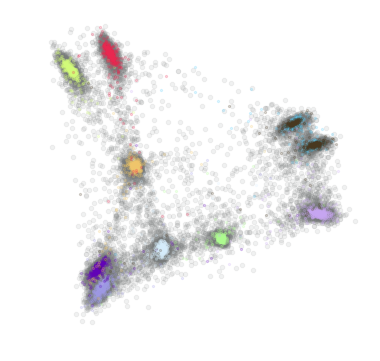

In [18]:
# reduce embedding to 2D and plot labelled and unlabelled training set samples
labels = [str(i) for i in range(n_clusters)]
pca_plot(dec.encoder, x[:m], cluster_centres, y=y_plot, labels=labels, lcolours=lcolours)

In [19]:
a = Input(shape=(784,)) # input layer
q = dec.model(a)
pred = MappingLayer(cluster_to_label_mapping, output_dim=n_classes, \
                    kernel_initializer=MapInitializer(cluster_to_label_mapping, n_classes))(q)
model = Model(inputs=a, outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [20]:
v = int(.75*split)
model.fit(x_train[:v], np_utils.to_categorical(y_train[:v], 10), \
          validation_data=(x_train[v:], np_utils.to_categorical(y_train[v:], 10)), epochs=10, batch_size=256)

Train on 3750 samples, validate on 1250 samples
Epoch 1/10
3750/3750 [==============================] - 2s - loss: 1.6637 - val_loss: 1.6153

In [21]:
# calculate the clustering accuracy after updating with volunteer provided labels
FoMs.append(cluster_acc(y_valid, dec.predict_clusters(x_valid)))
n_labelled = [0]

In [22]:
print(FoMs)

[0.87690000000000001, 0.9728]
